# Setup and Loading Dataset

### Importing Libraries

In [1]:
import os, itertools

import numpy as np 
import pandas as pd 
from pandas import DataFrame

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader,Dataset,WeightedRandomSampler

import torchvision
import torchvision.transforms as T
from torchvision import models 

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from skimage import io

In [2]:
torch.manual_seed(1234)

### Extraction of Images from directories and Labels from metadata.csv

In [3]:
metadata_csv = '/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv'
img_dir_1 = '/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1'
img_dir_2 = '/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_2'

Othe csv files do not contain new that and are from [this](https://www.kaggle.com/code/kmader/dermatology-mnist-loading-and-processing/notebook) <br>

In [4]:
metadata = pd.read_csv(metadata_csv)
metadata

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear
...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face


Multiple Images for each lesion exist, to avoid inflating validation accuracy we only chose one image per lesion

In [5]:
metadata = metadata.drop_duplicates(subset=['lesion_id'])
metadata = metadata.sample(frac = 1)

metadata.index = np.arange(0, len(metadata))
metadata

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0002401,ISIC_0028204,nv,follow_up,40.0,male,abdomen
1,HAM_0004076,ISIC_0032966,nv,histo,0.0,unknown,back
2,HAM_0004822,ISIC_0029788,nv,follow_up,45.0,female,lower extremity
3,HAM_0007570,ISIC_0026430,mel,histo,60.0,female,back
4,HAM_0000601,ISIC_0026578,nv,follow_up,40.0,female,abdomen
...,...,...,...,...,...,...,...
7465,HAM_0006291,ISIC_0026490,vasc,consensus,65.0,female,trunk
7466,HAM_0007578,ISIC_0030867,nv,follow_up,55.0,female,lower extremity
7467,HAM_0005187,ISIC_0029385,nv,follow_up,40.0,female,trunk
7468,HAM_0002656,ISIC_0027116,nv,follow_up,45.0,female,trunk


In [6]:
train_csv = metadata.iloc[1000:,:]
train_csv.index = np.arange(0, len(train_csv))

test_csv = metadata.iloc[:1000,:]

In [7]:
class CustomDataset(Dataset):# For Images in a root_dir_1(2) and labels in csv
    
    def __init__(self, metadata_pd, root_dir_1, root_dir_2, transform=None):
        self.metadata = metadata_pd
        self.root_dir_1 = root_dir_1
        self.root_dir_2 = root_dir_2
        self.transform = transform
        self.label_dict = {
            'nv': 0, 
            'mel': 1, 
            'bkl': 2,
            'bcc': 3,
            'akiec': 4,
            'vasc': 5,
            'df': 6
        } 
        
    def __len__(self):
        return len(self.metadata)
    
    def __getitem__(self, index):
        
        img_path = os.path.join(self.root_dir_1, self.metadata.iloc[index, 1]+'.jpg')
        
        if os.path.exists(img_path):
            image = io.imread(img_path)
            label = self.label_dict[self.metadata.iloc[index, 2]]
            
            if self.transform:
                image = self.transform(image)
            
            return(image, label)
        
        img_path = os.path.join(self.root_dir_2, self.metadata.iloc[index, 1]+'.jpg')
        
        if os.path.exists(img_path):
            image = io.imread(img_path)
            label = self.label_dict[self.metadata.iloc[index, 2]]
            
            if self.transform:
                image = self.transform(image)
            
            return(image, label)
        else:
            return None

In [8]:
train_transformation = T.Compose([
    T.ToTensor(),
    T.Resize((224, 280), antialias=True),
    T.CenterCrop((224, 224)),
    T.RandomHorizontalFlip(p=0.5),
    T.RandomApply(transforms=[T.RandomRotation(degrees=(-180, 180))], p=0.99),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
test_transformation = T.Compose([
    T.ToTensor(),
    T.Resize((224, 280), antialias=True),
    T.CenterCrop((224, 224)),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

train_data = CustomDataset(metadata_pd = train_csv, root_dir_1=img_dir_1, root_dir_2=img_dir_2, transform=train_transformation)
test_data = CustomDataset(metadata_pd = test_csv, root_dir_1=img_dir_1, root_dir_2=img_dir_2, transform=test_transformation)


val_data, test_data = torch.utils.data.random_split(test_data, [0.5,0.5])

# Visualization

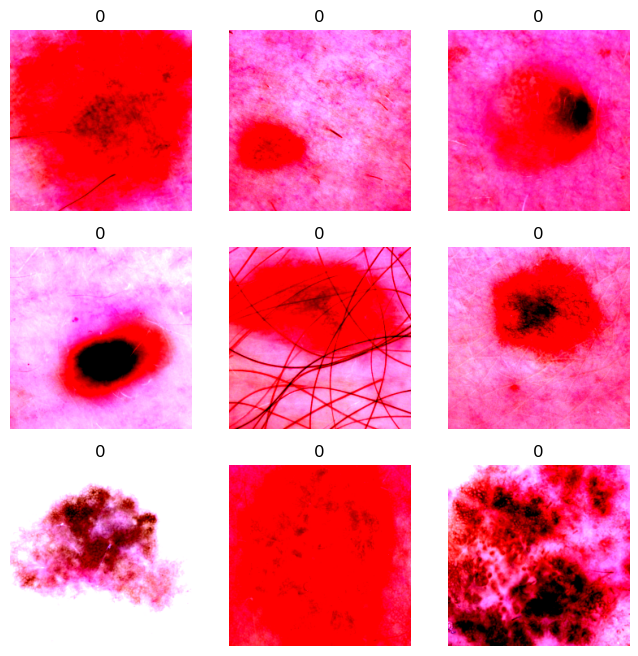

In [9]:
def display_data(dataset):
    figure = plt.figure(figsize=(8, 8))
    cols, rows = 3, 3

    for i in range(1, cols * rows + 1):
        sample_idx = torch.randint(len(dataset), size=(1,)).item()
        img, label = dataset[sample_idx]
        figure.add_subplot(rows, cols, i)
        plt.title(label)
        plt.axis("off")
        plt.imshow(img.permute(1, 2, 0))
    plt.show()

display_data(test_data)

# DataLoaders and Weighted Sampling

### Weighted Sampling

nv       5403
bkl       727
mel       614
bcc       327
akiec     228
vasc       98
df         73
Name: dx, dtype: int64

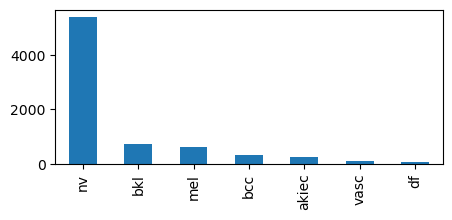

In [10]:
fig, ax1 = plt.subplots(1, 1, figsize = (5, 2))
metadata['dx'].value_counts().plot(kind='bar', ax=ax1)

metadata['dx'].value_counts()

This Dataset has Imbalanced Distribution of labels, thus Oversampling is used to create the DataLoader

In [11]:
array = metadata['dx'].value_counts()

class_weights = []
for i in range(len(array)):
    class_weights.append(1/array.iloc[i])

train_sample_weights = [0]*len(train_data)

for idx, (data, label) in enumerate(train_data):
    train_sample_weights[idx] = class_weights[label]

### Creating dataloaders for each dataset

In [12]:
b_s = 128

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [13]:
train_sampler = WeightedRandomSampler(train_sample_weights, num_samples=len(train_data), replacement=True)

train_loader = DataLoader(train_data, batch_size=b_s, sampler=train_sampler)
val_loader = DataLoader(val_data, batch_size=b_s)
test_loader = DataLoader(test_data, batch_size=b_s)

# Model Setup

In [14]:
target_labels = ['Melanocytic nevi',
                 'Melanoma',
                 'Benign keratosis like lesions ',
                 'Basal cell carcinoma',
                 'Actinic keratoses',
                 'Vascular lesions',
                 'Dermatofibroma']

In [15]:
num_classes = len(target_labels)

model = models.densenet121(weights='DenseNet121_Weights.IMAGENET1K_V1')

for param in model.parameters():
    param.requires_grad = False
    
num_features = model.classifier.in_features
model.classifier = nn.Linear(num_features, num_classes)

model = model.to(device)

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 290MB/s]


In [16]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)

### Some required functions

In [17]:
def save_checkpoint(state, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    torch.save(state, filename)

def load_checkpoint(checkpoint):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    
def get_accuracy(y_pred, y_true):
    _, predicted = torch.max(y_pred, 1)
    total = y_true.size(0)
    correct = (predicted == y_true).sum().item()
    accuracy = correct / total
    return accuracy

def plot_confusion_matrix(cm, classes,normalize=False, title='Confusion matrix with DenseNet121', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(6,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('confusion_matrix.png' , format="png", bbox_inches='tight')
    plt.show()

# Training

In [18]:
load_model = False

if load_model:
    load_checkpoint(torch.load('my_checkpoint.pth.tar'))

In [19]:
num_epochs = 200

for epoch in range(num_epochs):
    
    train_loss = 0.0
    train_acc = 0.0
    
    model.train()
    
    if epoch%3==0:
        checkpoint = {'state_dict' : model.state_dict(), 'optimizer' : optimizer.state_dict()}
        save_checkpoint(checkpoint)
        
    for data, labels in train_loader:
        
        data = data.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(data)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * data.size(0)
        train_acc += get_accuracy(outputs, labels) * data.size(0)
        
    train_acc = train_acc / len(train_data)
    train_loss = train_loss / len(train_data)
    
    val_loss = 0.0
    val_acc = 0.0
        
    for data, labels in val_loader:
        
        data = data.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        #Foward pass only
        outputs = model(data)
        loss = criterion(outputs, labels)
        
        val_loss += loss.item() * data.size(0)
        val_acc += get_accuracy(outputs, labels) * data.size(0)
    
    
    # Calculate average loss and accuracy for the epoch
    val_loss = val_loss / len(val_data)
    val_acc = val_acc / len(val_data)
    
    # Print training losses and accuracies for the epoch
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss:.4f}, Training Accuracy: {train_acc:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")

=> Saving checkpoint
Epoch 1/200, Training Loss: 1.5753, Training Accuracy: 0.4331, Validation Loss: 1.8761, Validation Accuracy: 0.3160
Epoch 2/200, Training Loss: 1.1582, Training Accuracy: 0.6167, Validation Loss: 1.7754, Validation Accuracy: 0.3880
Epoch 3/200, Training Loss: 1.0266, Training Accuracy: 0.6541, Validation Loss: 2.0586, Validation Accuracy: 0.3220
=> Saving checkpoint
Epoch 4/200, Training Loss: 0.9328, Training Accuracy: 0.6753, Validation Loss: 2.0233, Validation Accuracy: 0.3120
Epoch 5/200, Training Loss: 0.8952, Training Accuracy: 0.6896, Validation Loss: 1.8669, Validation Accuracy: 0.3760
Epoch 6/200, Training Loss: 0.8593, Training Accuracy: 0.7008, Validation Loss: 1.8922, Validation Accuracy: 0.3680
=> Saving checkpoint
Epoch 7/200, Training Loss: 0.8257, Training Accuracy: 0.7085, Validation Loss: 2.0954, Validation Accuracy: 0.3040
Epoch 8/200, Training Loss: 0.8190, Training Accuracy: 0.7142, Validation Loss: 1.8859, Validation Accuracy: 0.3420
Epoch 9/2

# Results

In [20]:
model.eval()

test_preds = []
test_labels = []

with torch.no_grad():
    
    test_acc = 0.0
    
    for data, labels in test_loader:
        
        data = data.to(device)
        labels = labels.to(device)
        
        outputs = model(data)
        
        _, preds = torch.max(outputs, 1)
        
        test_preds.extend(preds.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())
        
        test_acc += get_accuracy(outputs, labels) * data.size(0)
    
    test_acc = test_acc / len(test_data)
    
    print(f"Test Accuracy: {test_acc:.4f}")

Test Accuracy: 0.6840


In [21]:
report = classification_report(test_labels, test_preds, target_names=target_labels)

print(report)

                                precision    recall  f1-score   support

              Melanocytic nevi       0.97      0.75      0.84       352
                      Melanoma       0.42      0.49      0.45        45
Benign keratosis like lesions        0.39      0.45      0.42        49
          Basal cell carcinoma       0.55      0.75      0.63        24
             Actinic keratoses       0.33      0.57      0.42        21
              Vascular lesions       0.14      0.33      0.20         3
                Dermatofibroma       0.10      0.67      0.17         6

                      accuracy                           0.68       500
                     macro avg       0.41      0.57      0.45       500
                  weighted avg       0.80      0.68      0.73       500



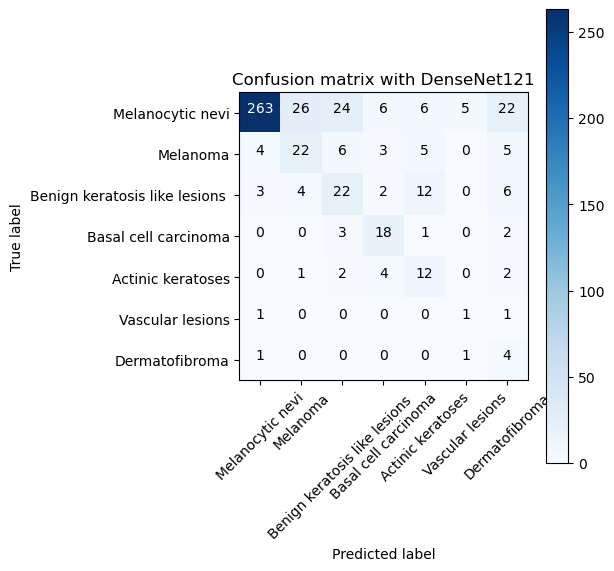

In [22]:
confusion_mtx = confusion_matrix(test_labels, test_preds)

plot_confusion_matrix(confusion_mtx, target_labels)